# 📊 Sales Uplift Analysis Tutorial

This notebook will guide you step by step through an **uplift analysis** to evaluate the effect of a marketing campaign.

We will:
1. Load the dataset
2. Explore the dataset
3. Perform Exploratory Data Analysis (EDA)
4. Conduct an A/B statistical test (t-test)
5. Draw a business conclusion
---

### Step 1 : Load the dataset

In [1]:
# 📌 Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
# 📌 Step 2: Load the dataset
df = pd.read_csv("C:\\Users\\Debarghya\\Data-Projects\\Machine Learning & Python Projects\\sales_data_with_marketing_intervention.csv")
df.head()

,Unnamed: 0,date,customer_id,product_id,quantity,unit_price,revenue,marketing_campaign
0,0,2021-01-01,372,58,4,42.01,168.04,False
1,1,2021-01-02,288,61,1,74.71,74.71,False
2,2,2021-01-03,130,24,3,36.74,110.22,False
3,3,2021-01-04,175,20,3,60.98,182.94,False
4,4,2021-01-05,462,37,2,52.84,105.68,False


### 🔍 Step 2: Explore the dataset
👉 *Which product generates highest revenues?*

👉 *Who are the best customers?*

👉 *What is the best time of the year of sales?*

#### Which product generates highest revenues?

In [5]:
# Grouping by product id and sum of revenue of each product group
product_revenue = df.groupby('product_id')['revenue'].sum()
#Product id and highest revenue
top_product_id = product_revenue.idxmax()
top_revenue = product_revenue.max()

print(f"product {top_product_id} generates highest revenue: {top_revenue}")

product 66 generates highest revenue: 2877.16


#### Who are the best customers?

In [8]:
# Group by customer_id and sum the revenue for each customer group
customer_revenue = df.groupby('customer_id')['revenue'].sum()

# Sort customers by total revenue in descending order
best_customers = customer_revenue.sort_values(ascending=False)

print(best_customers.head())  # Top customers by revenue

customer_id
459    1719.14
25     1572.96
391    1396.36
392    1390.48
309    1351.69
Name: revenue, dtype: float64


#### What is the best time of the year of sales?

In [10]:
# Convert 'date' column to datetime (if not already)
df['date'] = pd.to_datetime(df['date'])

# Extract month number (1 to 12) or month name if preferred
#df['month'] = df['date'].dt.month  # For month number
df['month_name'] = df['date'].dt.month_name()  # For month name

# Group by month and sum revenue
monthly_revenue = df.groupby('month_name')['revenue'].sum()

# Find the month with highest sales
best_month = monthly_revenue.idxmax()
best_month_sales = monthly_revenue.max()

print(f"Month {best_month} has the highest sales: {best_month_sales}")

Month August has the highest sales: 21736.48


### 📊 Step 3: Exploratory Data Analysis (EDA)



We will visualize the difference between campaign and non-campaign groups.

In [15]:
# Summary statistics grouped by campaign
df.groupby("marketing_campaign")["revenue"].describe()

,count,mean,std,min,25%,50%,75%,max
marketing_campaign,,,,,,,,
False,200.0,163.4612,129.122193,0.00,59.775,134.92,236.035,569.88
True,50.0,747.9458,374.462218,137.41,454.090,797.64,1025.250,1572.96


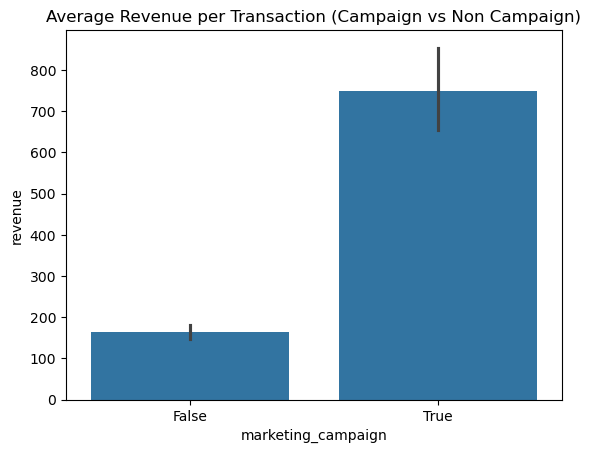

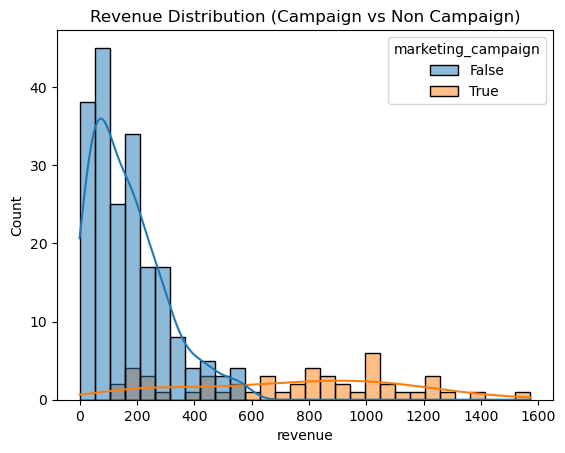

In [14]:
# Average revenue per transaction
sns.barplot(x="marketing_campaign", y="revenue", data=df, estimator=np.mean)
plt.title("Average Revenue per Transaction (Campaign vs Non Campaign)")
plt.show()

# Revenue distribution
sns.histplot(data=df, x="revenue", hue="marketing_campaign", kde=True, bins=30)
plt.title("Revenue Distribution (Campaign vs Non Campaign)")
plt.show()

### These graphs clearly shows that marketing campaign increased revenue and without marketing campaign revenue is very low. The campaign is needed to improve the sales.

### Sales trend Analysis

C:\Users\Debarghya\AppData\Local\Temp\ipykernel_9016\3300756399.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_revenue = df['revenue'].resample('M').sum()


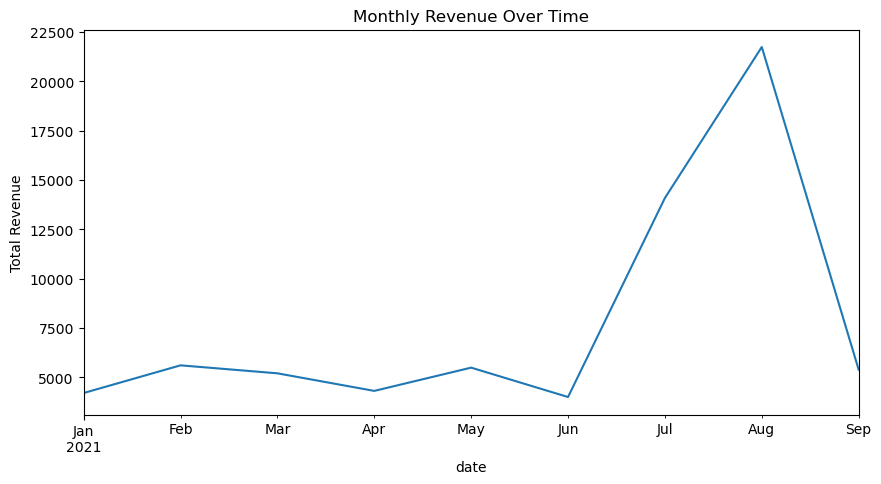

In [16]:
# Make sure 'date' column is datetime type
df['date'] = pd.to_datetime(df['date'])

# Set date as index for resampling
df.set_index('date', inplace=True)

# Daily revenue, groups by day
daily_revenue = df['revenue'].resample('D').sum()

# Weekly revenue, groups by week
weekly_revenue = df['revenue'].resample('W').sum()

# Monthly revenue, groups by month
monthly_revenue = df['revenue'].resample('M').sum()

# Example: Plot monthly revenue
plt.figure(figsize=(10, 5))
monthly_revenue.plot(title='Monthly Revenue Over Time')
plt.ylabel('Total Revenue')
plt.show()

### The revenue trend shows that revenue started increasing from the month of June to Aug and Aug has the highest sales. However the sales have been dropped in the month of September.

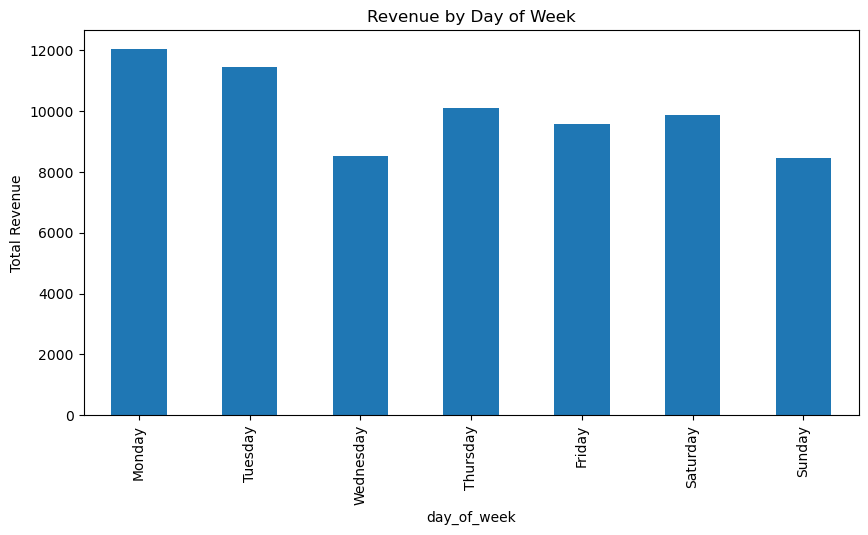

In [18]:
# Reset index (to access date columns)
df.reset_index(inplace=True)

# Extract useful features from date
df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.isocalendar().week
df['day_of_week'] = df['date'].dt.day_name()

# Aggregate revenue by month, week, day of week
monthly_pattern = df.groupby('month')['revenue'].sum()
weekly_pattern = df.groupby('week')['revenue'].sum()
dayofweek_pattern = df.groupby('day_of_week')['revenue'].sum()

# Order the day of week for plotting
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dayofweek_pattern = dayofweek_pattern.reindex(ordered_days)

# Plot day of week pattern
plt.figure(figsize=(10, 5))
dayofweek_pattern.plot(kind='bar', title='Revenue by Day of Week')
plt.ylabel('Total Revenue')
plt.show()


### Early weekdays, especially Monday and Tuesday, are the most profitable for sales. These could be the targeted marketing campaign dates.

### 📈 Step 4: Statistical Test (A/B Testing)
EDA gives us a visual clue, but we need to know if the difference is real or random chance.

We’ll run a t-test:

Null hypothesis (H₀): The campaign has no effect (means are equal)
Alternative hypothesis (H₁): The campaign increased revenue
If p < 0.05, we reject H₀ and say the campaign had a significant effect.

In [20]:
campaign_sales = df[df['marketing_campaign'] == True]['revenue']
control_sales = df[df['marketing_campaign'] == False]['revenue']

# T-test
t_stat, p_val = ttest_ind(campaign_sales, control_sales, equal_var=False)

# Calculate uplift percentage
uplift = (campaign_sales.mean() - control_sales.mean()) / control_sales.mean() * 100

print(f"Mean Revenue (Campaign): {campaign_sales.mean():.2f}")
print(f"Mean Revenue (Control): {control_sales.mean():.2f}")
print(f"Uplift: {uplift:.2f}%")
print(f"p-value: {p_val:.4f}")

Mean Revenue (Campaign): 747.95
Mean Revenue (Control): 163.46
Uplift: 357.57%
p-value: 0.0000


### Business Conclusion
If p < 0.05: The campaign significantly increased revenue.
If p >= 0.05: No evidence that the campaign had a real impact.